In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/IEM_MED-CovidProject'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

67

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,target,target_end_date,location,type,quantile,value
10180,2020-12-07,1 wk ahead inc case,2020-12-12,42,point,NaN,69898.061572
10188,2020-12-07,2 wk ahead inc case,2020-12-19,42,point,NaN,85416.531122
10196,2020-12-07,3 wk ahead inc case,2020-12-26,42,point,NaN,104104.195311
10204,2020-12-07,4 wk ahead inc case,2021-01-02,42,point,NaN,126022.921337
10148,2020-12-14,1 wk ahead inc case,2020-12-19,42,point,NaN,85381.221455


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,forecast_date,target,target_end_date,location,type,quantile,value
10180,2020-12-07,1 wk ahead inc case,2020-12-12,42,point,NaN,69898.061572
10188,2020-12-07,2 wk ahead inc case,2020-12-19,42,point,NaN,85416.531122
10148,2020-12-14,1 wk ahead inc case,2020-12-19,42,point,NaN,85381.221455
10196,2020-12-07,3 wk ahead inc case,2020-12-26,42,point,NaN,104104.195311
10156,2020-12-14,2 wk ahead inc case,2020-12-26,42,point,NaN,102815.380313
...,...,...,...,...,...,...,...
3828,2022-03-07,3 wk ahead inc case,2022-03-26,42,point,NaN,3143.677324
2068,2022-03-14,2 wk ahead inc case,2022-03-26,42,point,NaN,3897.654592
3828,2022-03-14,3 wk ahead inc case,2022-04-02,42,point,NaN,3146.490791
5588,2022-03-07,4 wk ahead inc case,2022-04-02,42,point,NaN,2366.248274


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(67, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2020-12-12,2020-12-07,1 wk ahead inc case,42,point,NaN,69898.061572,9985.437367
1,2020-12-19,2020-12-14,1 wk ahead inc case,42,point,NaN,85381.221455,12197.317351
2,2020-12-26,2020-12-21,1 wk ahead inc case,42,point,NaN,63374.789062,9053.541295
3,2021-01-02,2020-12-28,1 wk ahead inc case,42,point,NaN,48043.496077,6863.356582
4,2021-01-09,2021-01-04,1 wk ahead inc case,42,point,NaN,44324.519465,6332.074209


In [12]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[9985.437367410592, 9985.437367410592, 9985.437367410592, 9985.437367410592, 9985.437367410592, 9985.437367410592, 9985.437367410592, 12197.317350720043, 12197.317350720043, 12197.317350720043, 12197.317350720043, 12197.317350720043, 12197.317350720043, 12197.317350720043, 9053.541294642857, 9053.541294642857, 9053.541294642857, 9053.541294642857, 9053.541294642857, 9053.541294642857, 9053.541294642857, 6863.356582418885, 6863.356582418885, 6863.356582418885, 6863.356582418885, 6863.356582418885, 6863.356582418885, 6863.356582418885, 6332.074209226693, 6332.074209226693, 6332.074209226693, 6332.074209226693, 6332.074209226693, 6332.074209226693, 6332.074209226693, 7680.179118216433, 7680.179118216433, 7680.179118216433, 7680.179118216433, 7680.179118216433, 7680.179118216433, 7680.179118216433, 7043.701450796039, 7043.701450796039, 7043.701450796039, 7043.701450796039, 7043.701450796039, 7043.701450796039, 7043.701450796039, 4661.97153974516, 4661.97153974516, 4661.97153974516, 4661.97

In [13]:
len(predictions)

446

In [16]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-12-12') & (df1['Date'] <= '2022-03-04')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-12-12,19536,20485.8,999350,25603978,6234.2,6125.7,244955.3,2860489,-5275.682283,2774.207671
1,2020-12-13,16170,20764.0,1015520,25603978,4898.6,6256.4,249854.0,2860489,-5275.682283,2774.207671
2,2020-12-14,19956,20670.0,1035476,25603978,5564.0,6145.0,255417.5,2860489,-5275.682283,2774.207671
3,2020-12-15,20462,21261.4,1055938,25603978,6379.5,6340.8,261797.1,2860489,-5275.682283,2774.207671
4,2020-12-16,19456,20548.0,1075394,25603978,5930.3,6100.1,267727.4,2860489,-5275.682283,2774.207671


In [17]:
len(df1_copy)

446

In [18]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [20]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [21]:
merged_df_new.shape

(446, 12)

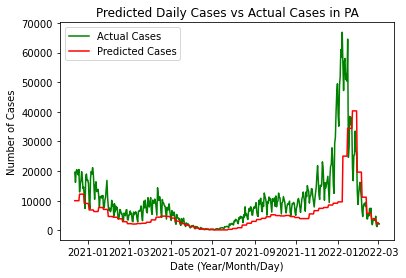

In [22]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [23]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

391
0.8766816143497758
55
0.12331838565022424
446
[0.48886991362558396, 0.3824714058496851, 0.49962731171524394, 0.5120009105947321, 0.48676822741516285, 0.4663618337211099, 0.5135224901388195, 0.05651938809405611, 0.2154047761018884, 0.27127988106583567, 0.38322626665048326, 0.3053919504145762, 0.13346708221653575, 0.16238721667902467, 0.10942934343469832, 0.2287651051361098, 0.5003564406929991, 0.52344766319387, 0.46097039207889634, 0.4673134093526208, 0.4267007792146114, 0.2927291238232806, 0.05489443921524574, 0.6071347119393884, 0.6543782565002072, 0.6375498213762735, 0.6753379100085675, 0.6455610110298036, 0.5672447916056116, 0.39533286772090404, 0.5836900585649776, 0.613473677864321, 0.5154519276686033, 0.5315127101785518, 0.5414198863538027, 0.33619886618699796, 0.03466828579481732, 0.3179237017569775, 0.3218983649817735, 0.3401907974040865, 0.2879492751514525, 0.347034592907972, 0.07877302500705737, 0.0702611601377984, 0.3105225674631911, 0.3703109734671876, 0.4965908054033705

In [24]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.511130086374416, 0.6175285941503149, 0.5003726882847561, 0.4879990894052679, 0.5132317725848372, 0.53363816627889, 0.48647750986118055, 0.9434806119059439, 0.7845952238981115, 0.7287201189341643, 0.6167737333495167, 0.6946080495854239, 0.8665329177834642, 0.8376127833209753, 0.8905706565653017, 0.7712348948638902, 0.4996435593070009, 0.47655233680612996, 0.5390296079211037, 0.5326865906473792, 0.5732992207853886, 0.7072708761767195, 0.9451055607847543, 0.3928652880606116, 0.3456217434997928, 0.3624501786237265, 0.32466208999143253, 0.35443898897019643, 0.4327552083943884, 0.604667132279096, 0.4163099414350224, 0.38652632213567895, 0.48454807233139674, 0.46848728982144816, 0.45858011364619733, 0.6638011338130021, 0.9653317142051827, 0.6820762982430225, 0.6781016350182265, 0.6598092025959135, 0.7120507248485475, 0.652965407092028, 0.9212269749929426, 0.9297388398622016, 0.6894774325368089, 0.6296890265328123, 0.5034091945966295, 0.41807344793423784, 0.6406859605963289, 0.5887814523547

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

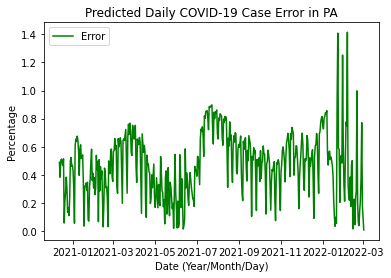

In [26]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

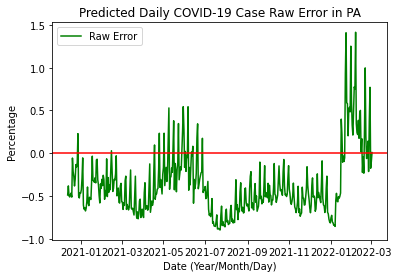

In [27]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

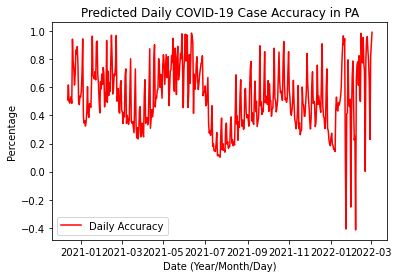

In [28]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [32]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [33]:
len(weeklyDateList)

64

In [34]:
#del averageWeeklyAccuracy[-1:]
len(averageWeeklyAccuracy)

64

In [35]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

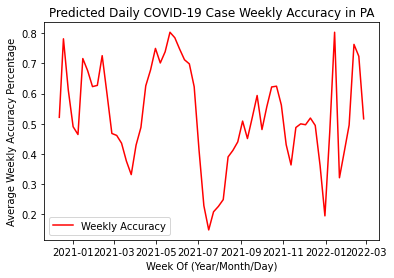

In [36]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [37]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [38]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

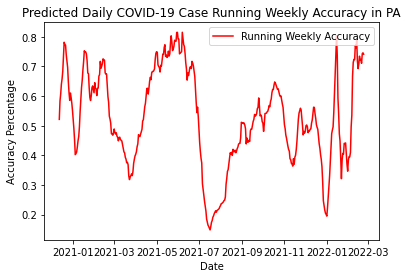

In [39]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

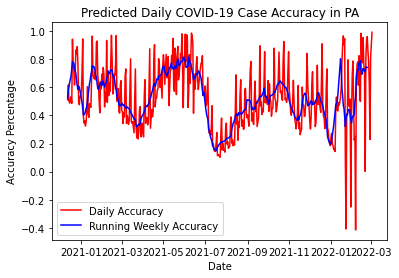

In [40]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [43]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [44]:
#del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

15

In [45]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

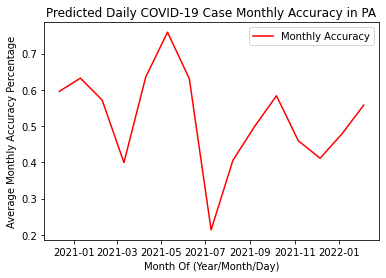

In [46]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [47]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [48]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

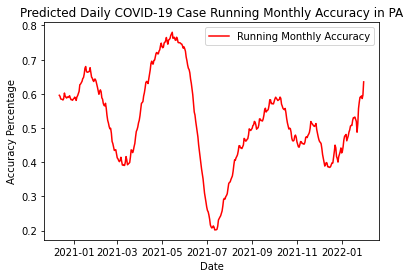

In [49]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [50]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [51]:
print(averageYearlyAccuracy)

[0.5308473092357029, 0.22841235823123926]


In [52]:
#Create Dataframe for Yearly Accuracy
i = 0
data = []
while i < len(averageYearlyAccuracy):
  data.append([weeklyDateListForYears[i], averageYearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Year Of', 'Average Yearly Accuracy'])

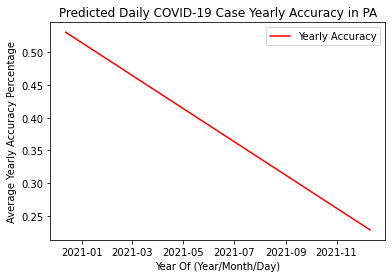

In [53]:
#Create plot of Yearly Accuracy

#Accuracy Line
plt.plot(df['Year Of'], df['Average Yearly Accuracy'], color='r', label='Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Year Of (Year/Month/Day)') 
plt.ylabel('Average Yearly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [54]:
#Calculate Running Yearly Accuracy

runningyearlyAccuracy = 0
runningAverageyearlyAccuracy = []
length = len(accuracy)

i = 1
j = 366
#Add first week average
runningAverageyearlyAccuracy.append(averageYearlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningyearlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageyearlyAccuracy.append(runningyearlyAccuracy / 365)
  runningyearlyAccuracy = 0

  i += 1
  j += 1

In [55]:
#Create Dataframe for Running Yearly Accuracy
i = 0
data = []
while i < len(runningAverageyearlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageyearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Yearly Average Accuracy'])

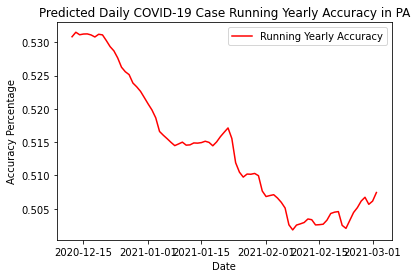

In [56]:
#Create plot of Running Yearly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Yearly Average Accuracy'], color='r', label='Running Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [57]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.528621908262925


In [58]:
#Create new dataframe for year 2022
data_2022 = merged_df_new[(merged_df_new['Date'] > '2022-01-01')]

In [59]:
#create error and accuracy lists for 2022
error_2022=[]
for index, row in data_2022.iterrows():
  error_2022.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

accuracy_2022 = []
for i in error_2022:
  accuracy_2022.append(1 - i)

In [60]:
#check head of 2022 data
data_2022.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
386,2022-01-02,35128,38695.9,4203914,25603978,6449.2,7426.4,1172327.7,2860489,-5275.682283,2774.207671,9595.19824,0.726850,0.273150,-0.726850
387,2022-01-03,48768,41456.9,4252682,25603978,9816.9,8055.2,1182144.5,2860489,-5275.682283,2774.207671,9595.19824,0.803248,0.196752,-0.803248
388,2022-01-04,51898,44396.0,4304580,25603978,10744.4,8691.2,1192888.2,2860489,-5275.682283,2774.207671,9595.19824,0.815114,0.184886,-0.815114
389,2022-01-05,61004,47411.2,4365584,25603978,11662.5,9215.5,1204551.4,2860489,-5275.682283,2774.207671,9595.19824,0.842712,0.157288,-0.842712
390,2022-01-06,58492,49136.1,4424076,25603978,12854.6,9728.8,1217406.1,2860489,-5275.682283,2774.207671,9595.19824,0.835957,0.164043,-0.835957


([<matplotlib.axis.XTick at 0x7f65792f62d0>,
 <a list of 9 Text major ticklabel objects>)

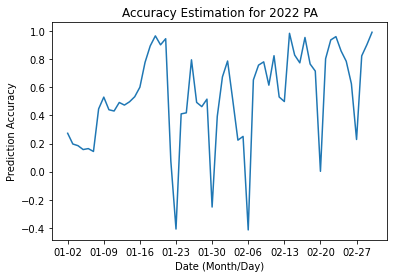

In [61]:
#create plot for 2022 accuracy
plt.xlabel('Date (Month/Day)') 
plt.ylabel('Prediction Accuracy') 
plt.title("Accuracy Estimation for 2022 PA")

plt.plot(data_2022['Date'].dt.strftime('%m-%d'), accuracy_2022, label='Accuracy 2022')
plt.xticks(np.arange(0, len(data_2022['Date']), 7))

In [62]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.511130086374416, 0.6175285941503149, 0.5003726882847561, 0.4879990894052679, 0.5132317725848372, 0.53363816627889, 0.48647750986118055, 0.9434806119059439, 0.7845952238981115, 0.7287201189341643, 0.6167737333495167, 0.6946080495854239, 0.8665329177834642, 0.8376127833209753, 0.8905706565653017, 0.7712348948638902, 0.4996435593070009, 0.47655233680612996, 0.5390296079211037, 0.5326865906473792, 0.5732992207853886, 0.7072708761767195, 0.9451055607847543, 0.3928652880606116, 0.3456217434997928, 0.3624501786237265, 0.32466208999143253, 0.35443898897019643, 0.4327552083943884, 0.604667132279096, 0.4163099414350224, 0.38652632213567895, 0.48454807233139674, 0.46848728982144816, 0.45858011364619733, 0.6638011338130021, 0.9653317142051827, 0.6820762982430225, 0.6781016350182265, 0.6598092025959135, 0.7120507248485475, 0.652965407092028, 0.9212269749929426, 0.9297388398622016, 0.6894774325368089, 0.6296890265328123, 0.5034091945966295, 0.41807344793423784, 0.6406859605963289, 0.5887814523547

In [63]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.05210770853047095
0.22827112942829839


In [64]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.5089901534540151


In [65]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021
# Omicron: December 1st 2021 - Present

In [66]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [76]:
merged_df_new.index[merged_df_new['Date']=='2021-05-20'].tolist()

[159]

In [77]:
merged_df_new.index[merged_df_new['Date']=='2021-12-01'].tolist()

[354]

In [78]:
#print(merged_inner)
standardVariantDF = merged_df_new[:159]
deltaVariantDF = merged_df_new[159:354]
omicronVariantDF = merged_df_new[354:]

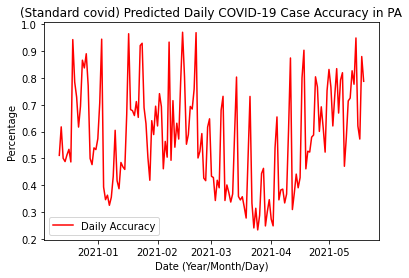

In [79]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

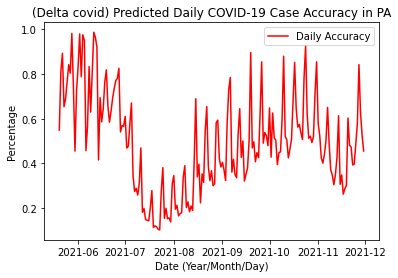

In [80]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

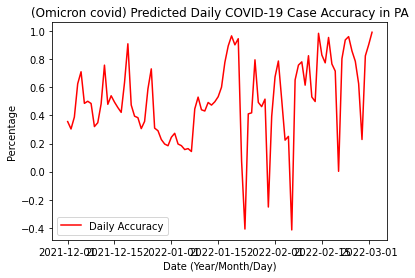

In [81]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(omicronVariantDF['Date'], omicronVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Omicron covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()